In [2]:
print('This is squeezenet model')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

img_height, img_width = 224, 224
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = '/root/data/train' 
test_dir = '/root/data/test'   

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.squeezenet1_0(pretrained=False)
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

torch.save(model.state_dict(), "squeezenet_model.pth")
print("Model saves to squeezenet_model.pth")

model.eval()
all_labels = []
all_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Top-1 accuracy: {accuracy * 100:.2f}%')

f1 = f1_score(all_labels, all_predictions, average='macro')
print(f'F1 score: {f1:.4f}')

final_results = {
    'Top-1 Accuracy': accuracy,
    'F1 Score': f1
}
print(f'final_result: {final_results}')


This is squeezenet model


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/20], Loss: 1.3922
Epoch [2/20], Loss: 0.6383
Epoch [3/20], Loss: 0.5166
Epoch [4/20], Loss: 0.4608
Epoch [5/20], Loss: 0.4182
Epoch [6/20], Loss: 0.3290
Epoch [7/20], Loss: 0.3072
Epoch [8/20], Loss: 0.2867
Epoch [9/20], Loss: 0.2711
Epoch [10/20], Loss: 0.2560
Epoch [11/20], Loss: 0.2072
Epoch [12/20], Loss: 0.1886
Epoch [13/20], Loss: 0.1748
Epoch [14/20], Loss: 0.1624
Epoch [15/20], Loss: 0.1508
Epoch [16/20], Loss: 0.1165
Epoch [17/20], Loss: 0.1037
Epoch [18/20], Loss: 0.0954
Epoch [19/20], Loss: 0.0882
Epoch [20/20], Loss: 0.0813
Model saves to squeezenet_model.pth
Top-1 accuracy: 91.92%
F1 score: 0.8462
final_result: {'Top-1 Accuracy': 0.9192328896589745, 'F1 Score': 0.8461845959070289}


The following evaluates a SqueezeNet model's performance on a test dataset, calculating metrics like F1 score and accuracy, and visualizes the best and worst predictions with top-5 probabilities. We choose the same 5 fashion-item to have consistent comparison to see the difference caused by models.

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Testing Progress:
Progress: 100.00%
Macro F1 Score: 0.7719
Accuracy: 0.8777

Selected file paths:
File: /root/data/test/bag/102784872_4.jpg, True: bag, Predicted: bag
File: /root/data/test/earrings/12690998_10.jpg, True: earrings, Predicted: earrings
File: /root/data/test/eyewear/120631641_10.jpg, True: eyewear, Predicted: eyewear
File: /root/data/test/gloves/67951070_6.jpg, True: gloves, Predicted: brooch
File: /root/data/test/rings/78167019_5.jpg, True: rings, Predicted: watches


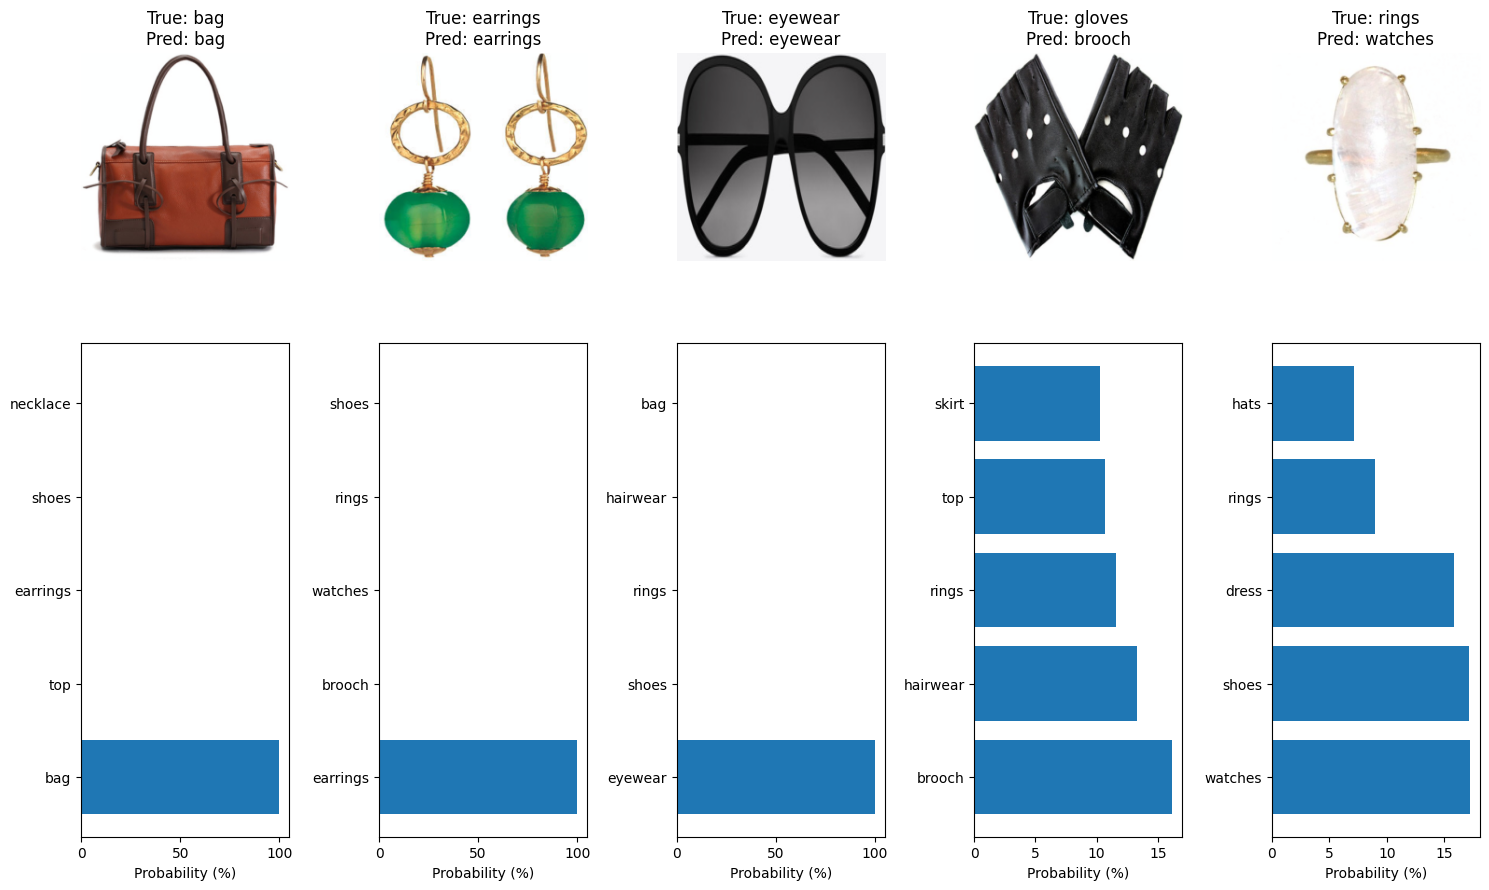

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import sys

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define image transformations (same as during training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dir = "/root/data/test"  # Test dataset path
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load SqueezeNet model and weights
model = models.squeezenet1_0(pretrained=False)
model.classifier[1] = torch.nn.Conv2d(512, 20, kernel_size=(1, 1), stride=(1, 1))  # Assuming 20 classes
model.num_classes = 20
model.load_state_dict(torch.load("/root/squeezenet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Class names
class_names = test_dataset.classes

# Initialize lists for F1 score calculation
all_labels = []
all_preds = []
all_file_paths = []

print("Testing Progress:")
with torch.no_grad():
    all_images = []
    all_outputs = []
    all_labels_tensor = []
    
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Collect labels and predictions for F1 score and accuracy calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_file_paths.extend([test_dataset.samples[i][0] for i in range(batch_idx * test_loader.batch_size, batch_idx * test_loader.batch_size + labels.size(0))])
        
        # Collect images, outputs, and labels for visualization
        all_images.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
        all_labels_tensor.append(labels.cpu())

        # Show progress
        progress = (batch_idx + 1) / len(test_loader) * 100
        sys.stdout.write(f"\rProgress: {progress:.2f}%")
        sys.stdout.flush()

    # Concatenate all batches
    all_images = torch.cat(all_images, dim=0)
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels_tensor = torch.cat(all_labels_tensor, dim=0)

# Calculate macro F1 score and accuracy
macro_f1 = f1_score(all_labels, all_preds, average='macro')
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nMacro F1 Score: {macro_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Identify correct and incorrect indices
correct_indices = np.where(np.array(all_preds) == np.array(all_labels))[0]
incorrect_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]

# Collect confidence scores for correct and incorrect predictions
correct_confidences = [(idx, all_outputs[idx].softmax(dim=0).max().item(), all_labels_tensor[idx].item()) for idx in correct_indices]
incorrect_confidences = [(idx, all_outputs[idx].softmax(dim=0).max().item()) for idx in incorrect_indices]

# Sort correct predictions by confidence and select unique categories
correct_confidences = sorted(correct_confidences, key=lambda x: x[1], reverse=True)
selected_correct_indices = []
selected_categories = set()

for idx, confidence, label in correct_confidences:
    if class_names[label] not in selected_categories:
        selected_correct_indices.append(idx)
        selected_categories.add(class_names[label])
    if len(selected_correct_indices) == 3:
        break

# Sort incorrect predictions by lowest confidence
incorrect_confidences = sorted(incorrect_confidences, key=lambda x: x[1])[:2]
selected_incorrect_indices = [x[0] for x in incorrect_confidences]

# Combine selected indices for visualization
selected_indices = np.concatenate([selected_correct_indices, selected_incorrect_indices])

# Print selected file paths for best and worst predictions
print("\nSelected file paths:")
for idx in selected_indices:
    print(f"File: {all_file_paths[idx]}, True: {class_names[all_labels_tensor[idx]]}, Predicted: {class_names[all_preds[idx]]}")

# Plotting the selected images with top-1 and top-5 predictions
plt.figure(figsize=(15, 10))
for i, idx in enumerate(selected_indices):
    image = all_images[idx].numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    label = class_names[all_labels_tensor[idx]]
    output = all_outputs[idx]
    top5_prob, top5_idx = torch.topk(output.softmax(dim=0), 5)
    top5_labels = [class_names[i] for i in top5_idx]

    # Display image with true label and top-1 prediction
    plt.subplot(2, len(selected_indices), i + 1)
    plt.imshow(image)
    plt.title(f"True: {label}\nPred: {top5_labels[0]}")
    plt.axis('off')

    # Display Top-5 prediction probabilities as a bar chart
    plt.subplot(2, len(selected_indices), len(selected_indices) + i + 1)
    plt.barh(top5_labels, (top5_prob.numpy() * 100).clip(0, 100))
    plt.xlabel('Probability (%)')

plt.tight_layout()
plt.show()
